# 0. Imports

In [22]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier

In [23]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# 1. EDA

**Let's start by checking for missing data.**

In [24]:
train_missing = train_df.isnull().sum()
train_missing_percentage = (train_missing / len(train_df)) * 100

train_missing_percentage[train_missing_percentage > 0].sort_values(ascending=False)

Cabin       77.104377
Age         19.865320
Embarked     0.224467
dtype: float64

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [26]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Univariate analysis**

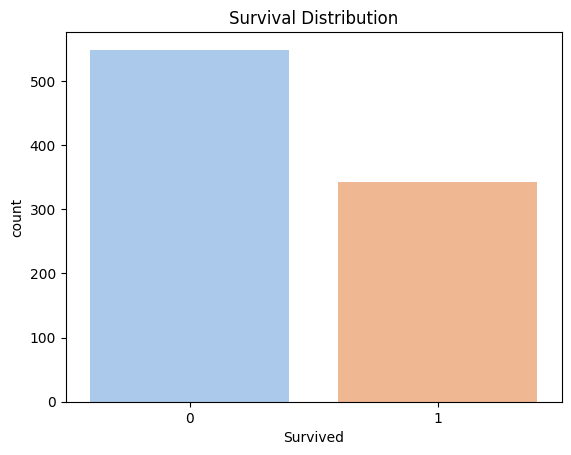

In [27]:
sns.countplot(data=train_df, x='Survived', palette='pastel')
plt.title('Survival Distribution')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


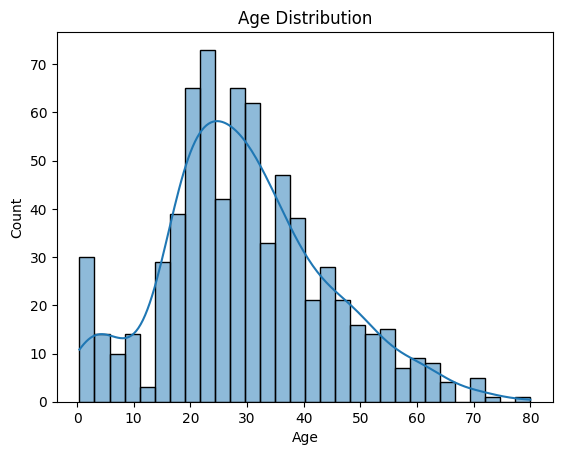

In [28]:
sns.histplot(train_df['Age'].dropna(), kde=True, bins=30)
plt.title('Age Distribution')
plt.show()

**Bivariate analysis**

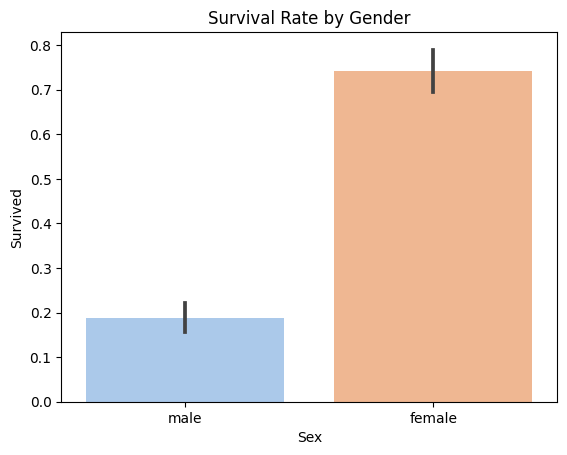

In [29]:
sns.barplot(x='Sex', y='Survived', data=train_df, palette='pastel')
plt.title('Survival Rate by Gender')
plt.show()

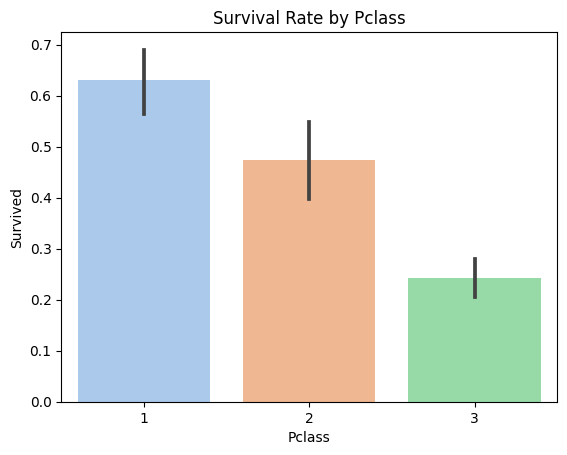

In [30]:
sns.barplot(x='Pclass', y='Survived', data=train_df, palette='pastel')
plt.title('Survival Rate by Pclass')
plt.show()

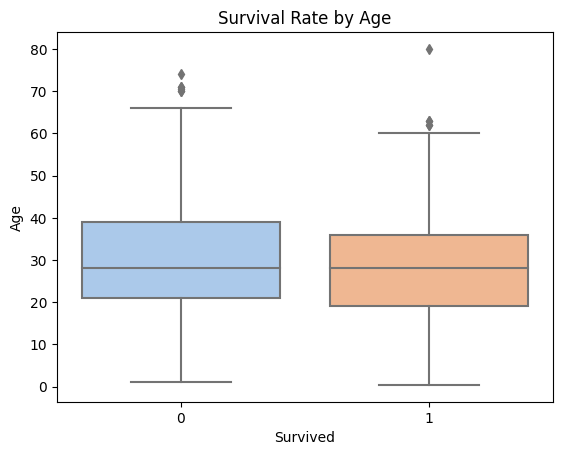

In [31]:
sns.boxplot(x='Survived', y='Age', data=train_df, palette='pastel')
plt.title('Survival Rate by Age')
plt.show()

**Multivariate analysis**

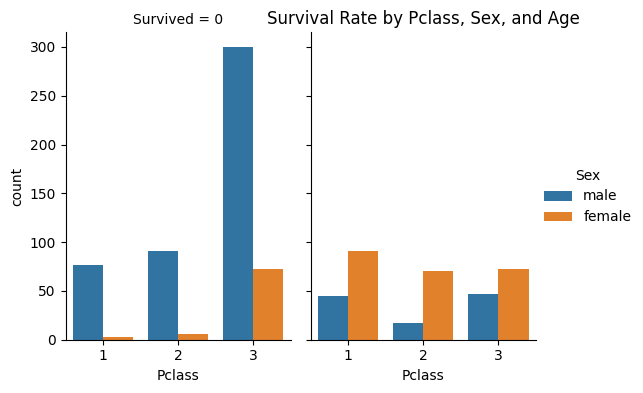

In [32]:
sns.catplot(x='Pclass', hue='Sex', col='Survived', data=train_df, kind='count', height=4, aspect=0.7)
plt.title('Survival Rate by Pclass, Sex, and Age')
plt.show()

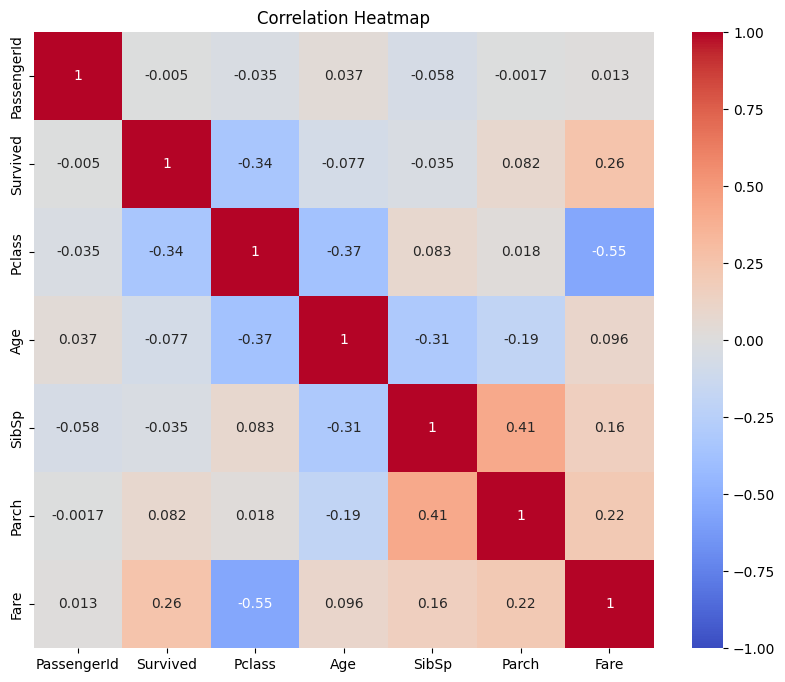

In [33]:
numeric_cols = train_df.select_dtypes(include=['number'])

corr = numeric_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


# 2. Feature engineering

Changing all fares equal to 0 to the median price for their class.

In [34]:
train_df.loc[train_df['Fare'] == 0, 'Fare'] = train_df.groupby('Pclass')['Fare'].transform('median')
test_df.loc[test_df['Fare'] == 0, 'Fare'] = test_df.groupby('Pclass')['Fare'].transform('median')
train_df['Fare'] = train_df.groupby('Pclass')['Fare'].transform('median')
test_df['Fare'] = test_df.groupby('Pclass')['Fare'].transform('median')

Extracting the title from the 'Name' column, as it could be relevant to the social class of the passenger.

In [35]:
train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

Let's now extract relevant information from the 'Ticket' column (two first letters, ticket length, cabin number, first letter of cabin).

In [36]:
train_df['Ticket_2letter'] = train_df['Ticket'].apply(lambda x: x[:2])
test_df['Ticket_2letter'] = test_df['Ticket'].apply(lambda x: x[:2])

In [37]:
train_df['Ticket_len'] = train_df['Ticket'].apply(lambda x: len(x))
test_df['Ticket_len'] = test_df['Ticket'].apply(lambda x: len(x))

In [38]:
train_df['Cabin_num'] = train_df['Ticket'].apply(lambda x: len(x.split()))
test_df['Cabin_num'] = test_df['Ticket'].apply(lambda x: len(x.split()))

In [39]:
train_df['Cabin_1letter'] = train_df['Ticket'].apply(lambda x: x[:1])
test_df['Cabin_1letter'] = test_df['Ticket'].apply(lambda x: x[:1])

Finally, let's get the family size.

In [40]:
train_df['Fam_size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Fam_size'] = test_df['SibSp'] + test_df['Parch'] + 1

# Model training

## RF model training

In [41]:
y = train_df['Survived']
features = ['Pclass', 'Fare', 'Title', 'Embarked', 'Fam_size', 'Ticket_len', 'Ticket_2letter']
X = train_df[features]

In [43]:
numerical_cols = ['Fare']
categorical_cols = ['Pclass', 'Title', 'Embarked', 'Fam_size', 'Ticket_len', 'Ticket_2letter']

# Inputting numerical values with median
# numerical_transformer = SimpleImputer(strategy='median')

# Inputting missing values with most frequent one for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        # ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Bundle preprocessing and modeling code
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5))
])

# Training
titanic_pipeline.fit(X, y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

Cross validation score: 0.823


In [44]:
X_test = test_df[features]

In [45]:
predictions_rf= titanic_pipeline.predict(X_test)

In [46]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions_rf})
output.to_csv('submission_rf.csv', index=False)

## XGBoost model training

In [47]:
# Bundle preprocessing and modeling code
titanic_pipeline_XGBoost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=0, n_estimators=500, max_depth=5, use_label_encoder=False, eval_metric='logloss'))
])

# Training
titanic_pipeline_XGBoost.fit(X, y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline_XGBoost, X, y, cv=10).mean()))

Cross validation score: 0.825


In [48]:
predictions_xgboost = titanic_pipeline_XGBoost.predict(X_test)

In [49]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions_xgboost})
output.to_csv('submission_XGBoost.csv', index=False)